In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

参考[[Sigmoid 函数]]中的公式

$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$

In [2]:
def sigmoid(z) -> np.ndarray:
    """Sigmoid函数

    Args:
        z (np.ndarray): 函数的计算结果，在当前模型中是一个标量

    Returns:
        np.ndarray: 经过激活后的函数计算结果
    """
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

In [3]:
def layer_sizes(X: np.ndarray, Y: np.ndarray, n_h: int = 4) -> Tuple[int, int, int]:
    """定义网络结构，获取输入层、隐藏层和输出层的大小 [cite: 291-307]

    Args:
        X (np.ndarray): 训练输入，形状为 (n_x, m) m为特征[cite: 295, 302]
        Y (np.ndarray): 训练输出标签，形状为 (n_y, m) m为特征[cite: 296, 306]

    Returns:
        Tuple[int, int, int]:
            - n_x: 输入层大小 [cite: 298]
            - n_h: 隐藏层大小 (通常在此函数内手动指定，如 4) [cite: 299, 304]
            - n_y: 输出层大小 [cite: 300]
    """
    n_x = X.shape[0]
    n_y = Y.shape[0]
    return n_x, n_h, n_y

In [4]:
def initialize_parameters(n_x: int, n_h: int, n_y: int) -> Dict[str, np.ndarray]:
    """初始化模型参数，权重随机初始化，偏置初始化为零 [cite: 310-331]

    Args:
        n_x (int): 输入层神经元个数 [cite: 314]
        n_h (int): 隐藏层神经元个数 [cite: 315]
        n_y (int): 输出层神经元个数 [cite: 316]

    Returns:
        Dict[str, np.ndarray]: 包含初始化后参数的字典:
            - "W1": 隐藏层权重，形状为 (n_h, n_x) [cite: 320, 327]
            - "b1": 隐藏层偏置，形状为 (n_h, 1) [cite: 322, 328]
            - "W2": 输出层权重，形状为 (n_y, n_h) [cite: 323, 329]
            - "b2": 输出层偏置，形状为 (n_y, 1) [cite: 324, 330]
    """
    rng = np.random.default_rng()

    W1 = rng.random((n_h, n_x)) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = rng.random((n_y, n_h)) * 0.01
    b2 = np.zeros((n_y, 1))

    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

这里 `X` 经过了四个表达式，分别是：

$$Z_1 = w_1 X + b1$$

$$A_1 = \tanh(Z_1)$$

$$Z_2 = w_2 A_1 + b2$$

$$A_2 = \sigma(Z_2)$$

最后得到的 `A2` 即 $\hat{y}$

In [5]:
def forward_propagation(X: np.ndarray, parameters: Dict[str, np.ndarray]) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    """定义前向传播过程 (隐藏层使用 tanh，输出层使用 sigmoid) [cite: 332, 345-368]

    Args:
        X (np.ndarray): 训练输入 [cite: 348]
        parameters (Dict[str, np.ndarray]): 包含当前模型参数的字典 [cite: 349]

    Returns:
        Tuple[np.ndarray, Dict[str, np.ndarray]]:
            - A2: 模型的输出 (预测值) [cite: 351]
            - cache: 前向传播过程计算的中间值缓存字典，包含 "Z1", "A1", "Z2", "A2" [cite: 352, 364-367]
    """
    Z1 = parameters['W1'] @ X + parameters['b1']
    A1 = np.tanh(Z1)
    Z2 = parameters['W2'] @ A1 + parameters['b2']
    A2 = sigmoid(Z2)

    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }

    return A2, cache

参考[[对数损失#交叉熵损失函数]]中的公式：

$$
J(w,b)=-\frac{1}{m} \sum_{i=1}^m ​[y_i​ln(\hat{y}_{i}​)+(1−y_i​)ln(1−\hat{y}_{i}​)]
$$

In [6]:
def loss(A2: np.ndarray, Y: np.ndarray) -> float:
    """定义基于交叉熵的损失函数 [cite: 370-390]

    Args:
        A2 (np.ndarray): 前向计算输出结果 [cite: 377]
        Y (np.ndarray): 真实训练标签 [cite: 379]

    Returns:
        float: 当前计算出的交叉熵损失 [cite: 381, 384]
    """
    A2 = np.clip(A2, 1e-15, 1 - 1e-15)
    return -np.mean(Y * np.log(A2)+ (1-Y) * np.log(1-A2))

参考[[神经网络#梯度下降]]，我们需要求得 $\frac{\partial Z_1}{\partial w_1}$ $\frac{\partial Z_1}{\partial b_1}$ $\frac{\partial Z_2}{\partial w_2}$ $\frac{\partial Z_2}{\partial b_2}$,将上面所有的公式进行偏导数的反推，可得：

$$\begin{align}

\frac{\partial L}{\partial A_2} &=\frac{A_2-Y}{A_2(1-A_2)} \\

\frac{\partial A_2}{\partial Z_2} &=A_2(1-A_2) \\

\frac{\partial Z_2}{\partial b_2} &=1 \\

\frac{\partial Z_2}{\partial w_2} &=A_1 \\

\frac{\partial Z_2}{\partial A_1} &=w_2 \\

\frac{\partial A_1}{\partial Z_1} &=1-\tanh^2(Z_1)=1-A_1^2 \\

\frac{\partial Z_1}{\partial b_1} &=1 \\

\frac{\partial Z_1}{\partial w_1} &=X \\

\end{align}$$

根据上面的式子，再结合链式法则，实现下面的代码

In [7]:
def backward_propagation(parameters: Dict[str, np.ndarray],
                         cache: Dict[str, np.ndarray],
                         X: np.ndarray, Y: np.ndarray) -> Dict[str, np.ndarray]:
    """定义反向传播过程，计算损失函数关于各个参数的梯度 [cite: 391-439]

    Args:
        parameters (Dict[str, np.ndarray]): 神经网络参数字典 [cite: 404]
        cache (Dict[str, np.ndarray]): 神经网络前向计算中间缓存字典

    Returns:
        Dict[str, np.ndarray]: 包含所有权重和偏置梯度的字典:
            - "dW1", "db1", "dW2", "db2" [cite: 409, 433-438]
    """
    m = X.shape[1]
    dZ2 = cache['A2'] - Y
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    dW2 = (dZ2 @ cache['A1'].T) / m
    dZ1 = parameters['W2'].T @ dZ2 * (1 - cache['A1'] ** 2)
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    dW1 = (dZ1 @ X.T) / m

    return {"dW1":dW1, "db1":db1, "dW2":dW2, "db2":db2}

In [8]:
def update_parameters(parameters: Dict[str, np.ndarray],
                      grads: Dict[str, np.ndarray],
                      learning_rate: float = 1.2) -> Dict[str, np.ndarray]:
    """根据梯度下降法更新模型的权重和偏置参数 [cite: 440-476]

    Args:
        parameters (Dict[str, np.ndarray]): 神经网络当前参数字典 [cite: 446]
        grads (Dict[str, np.ndarray]): 反向传播计算得到的权重梯度字典 [cite: 447]
        learning_rate (float, optional): 学习率，默认 1.2。 [cite: 448]

    Returns:
        Dict[str, np.ndarray]: 更新后的模型参数字典 [cite: 450, 471-476]
    """
    parameters['W1'] -= learning_rate * grads['dW1']
    parameters['W2'] -= learning_rate * grads['dW2']
    parameters['b1'] -= learning_rate * grads['db1']
    parameters['b2'] -= learning_rate * grads['db2']

    return parameters

In [9]:
def nn_model(X: np.ndarray,
             Y: np.ndarray,
             n_h: int = 4,
             num_iterations: int = 10001,
             print_cost: bool = False) -> Dict[str, np.ndarray]:
    """整合前面的模块，封装成一个完整的神经网络训练模型 [cite: 477-518]

    Args:
        X (np.ndarray): 训练输入 [cite: 485]
        Y (np.ndarray): 训练输出 [cite: 486]
        n_h (int, optional): 隐藏层结点数，默认 4。 [cite: 487]
        num_iterations (int, optional): 梯度下降迭代次数，默认 10000。 [cite: 488]
        print_cost (bool, optional): 训练过程中是否每 1000 次打印一次损失，默认 False。 [cite: 489, 516]

    Returns:
        Dict[str, np.ndarray]: 神经网络训练优化后的最终权重系数 [cite: 491, 518]
    """
    n_x, n_h, n_y = layer_sizes(X, Y, n_h)
    parameters = initialize_parameters(n_x, n_h, n_y)
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = loss(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        if print_cost is True and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [10]:
def create_dataset():
    np.random.seed(2)
    m = 400 # 数据量
    N = int(m/2) # 每个标签的实例数
    D = 2 # 数据维度
    X = np.zeros((m,D)) # 数据矩阵
    Y = np.zeros((m,1), dtype='uint8') # 标签维度
    a = 4

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

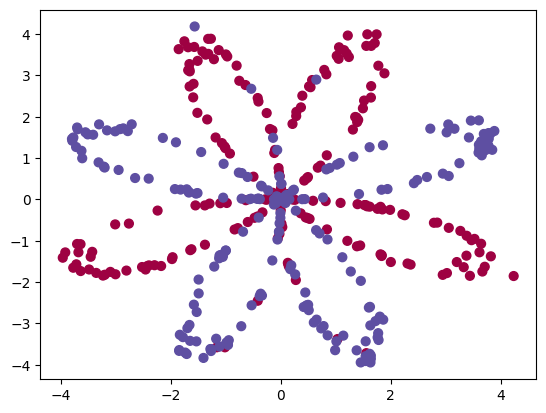

In [11]:
X, Y = create_dataset()
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

In [12]:
hat_y = nn_model(X, Y, print_cost=True)

Cost after iteration 0: 0.693188
Cost after iteration 1000: 0.251737
Cost after iteration 2000: 0.247291
Cost after iteration 3000: 0.242818
Cost after iteration 4000: 0.240476
Cost after iteration 5000: 0.238917
Cost after iteration 6000: 0.237783
Cost after iteration 7000: 0.236907
Cost after iteration 8000: 0.236200
Cost after iteration 9000: 0.235612
Cost after iteration 10000: 0.235110


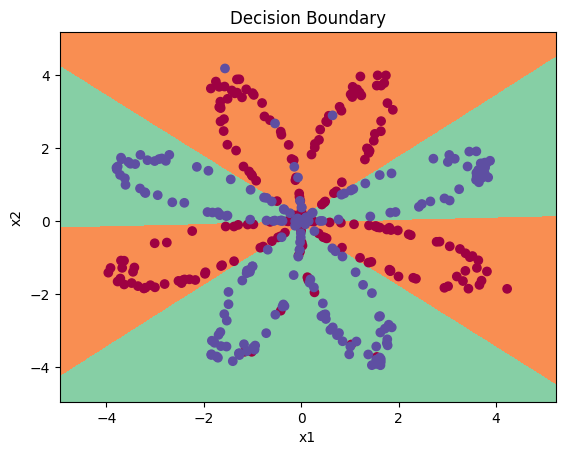

In [13]:
def plot_decision_boundary(model, X, y):
    # 设置最大值和最小值，并增加一些边缘
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    # 生成网格矩阵
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 预测整个网格中每个点的类别
    # 这里需要把 grid 展平后传入 forward_propagation
    Z, _ = model(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z > 0.5 # 阈值分类
    Z = Z.reshape(xx.shape)

    # 绘制轮廓和散点
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y[0], cmap=plt.cm.Spectral)
    plt.title("Decision Boundary")
    plt.show()

# 使用我们训练好的 parameters 来预测
# 我们需要把 forward_propagation 包装一下，只接受 X 输入，方便绘图函数调用
plot_decision_boundary(lambda x: forward_propagation(x, hat_y), X, Y)